# **TikTok Project**
**Course 6 - The Nuts and bolts of machine learning**

Recall that you are a data professional at TikTok. Your supervisor was impressed with the work you have done and has requested that you build a machine learning model that can be used to determine whether a video contains a claim or whether it offers an opinion. With a successful prediction model, TikTok can reduce the backlog of user reports and prioritize them more efficiently.

A notebook was structured and prepared to help you in this project. A notebook was structured and prepared to help you in this project. Please complete the following questions.

# **Course 6 End-of-course project: Classifying videos using machine learning**

In this activity, you will practice using machine learning techniques to predict on a binary outcome variable.
<br/>

**The purpose** of this model is to increase response time and system efficiency by automating the initial stages of the claims process.

**The goal** of this model is to predict whether a TikTok video presents a "claim" or presents an "opinion".
<br/>

*This activity has three parts:*

**Part 1:** Ethical considerations
* Consider the ethical implications of the request

* Should the objective of the model be adjusted?

**Part 2:** Feature engineering

* Perform feature selection, extraction, and transformation to prepare the data for modeling

**Part 3:** Modeling

* Build the models, evaluate them, and advise on next steps

Follow the instructions and answer the questions below to complete the activity. Then, you will complete an Executive Summary using the questions listed on the PACE Strategy Document.

Be sure to complete this activity before moving on. The next course item will provide you with a completed exemplar to compare to your own work.



# **Classify videos using machine learning**

<img src="images/Pace.png" width="100" height="100" align=left>

# **PACE stages**


Throughout these project notebooks, you'll see references to the problem-solving framework PACE. The following notebook components are labeled with the respective PACE stage: Plan, Analyze, Construct, and Execute.

<img src="images/Plan.png" width="100" height="100" align=left>


## **PACE: Plan**

Consider the questions in your PACE Strategy Document to reflect on the Plan stage.

In this stage, consider the following questions:


1.   **What are you being asked to do? What metric should I use to evaluate success of my business/organizational objective?**

2.   **What are the ethical implications of the model? What are the consequences of your model making errors?**
  *   What is the likely effect of the model when it predicts a false negative (i.e., when the model says a video does not contain a claim and it actually does)?

  *   What is the likely effect of the model when it predicts a false positive (i.e., when the model says a video does contain a claim and it actually does not)?

3.   **How would you proceed?**


**1. What are you being asked to do?**

**Business need and modeling objective**

TikTok users can report videos that they believe violate the platform's terms of service. Because there are millions of TikTok videos created and viewed every day, this means that many videos get reported&mdash;too many to be individually reviewed by a human moderator.

Analysis indicates that when authors do violate the terms of service, they're much more likely to be presenting a claim than an opinion. Therefore, it is useful to be able to determine which videos make claims and which videos are opinions.

TikTok wants to build a machine learning model to help identify claims and opinions. Videos that are labeled opinions will be less likely to go on to be reviewed by a human moderator. Videos that are labeled as claims will be further sorted by a downstream process to determine whether they should get prioritized for review. For example, perhaps videos that are classified as claims would then be ranked by how many times they were reported, then the top x% would be reviewed by a human each day.

A machine learning model would greatly assist in the effort to present human moderators with videos that are most likely to be in violation of TikTok's terms of service.

**Modeling design and target variable**

The data dictionary shows that there is a column called `claim_status`. This is a binary value that indicates whether a video is a claim or an opinion. This will be the target variable. In other words, for each video, the model should predict whether the video is a claim or an opinion.

This is a classification task because the model is predicting a binary class.

**Select an evaluation metric**

To determine which evaluation metric might be best, consider how the model might be wrong. There are two possibilities for bad predictions:

  - **False positives:** When the model predicts a video is a claim when in fact it is an opinion
  - **False negatives:** When the model predicts a video is an opinion when in fact it is a claim


**2. What are the ethical implications of building the model?**
In the given scenario, it's better for the model to predict false positives when it makes a mistake, and worse for it to predict false negatives. It's very important to identify videos that break the terms of service, even if that means some opinion videos are misclassified as claims. The worst case for an opinion misclassified as a claim is that the video goes to human review. The worst case for a claim that's misclassified as an opinion is that the video does not get reviewed _and_ it violates the terms of service. A video that violates the terms of service would be considered posted from a "banned" author, as referenced in the data dictionary.

Because it's more important to minimize false negatives, the model evaluation metric will be **recall**.

**3. How would you proceed?**

**Modeling workflow and model selection process**

Previous work with this data has revealed that there are ~20,000 videos in the sample. This is sufficient to conduct a rigorous model validation workflow, broken into the following steps:

1. Split the data into train/validation/test sets (60/20/20)
2. Fit models and tune hyperparameters on the training set
3. Perform final model selection on the validation set
4. Assess the champion model's performance on the test set

![](https://raw.githubusercontent.com/adacert/tiktok/main/optimal_model_flow_numbered.svg)


### **Task 1. Imports and data loading**

Start by importing packages needed to build machine learning models to achieve the goal of this project.

In [1]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

Now load the data from the provided csv file into a dataframe.

**Note:** As shown in this cell, the dataset has been automatically loaded in for you. You do not need to download the .csv file, or provide more code, in order to access the dataset and proceed with this lab. Please continue with this activity by completing the following instructions.

In [2]:
# Load dataset into dataframe
data = pd.read_csv("tiktok_dataset.csv")

<img src="images/Analyze.png" width="100" height="100" align=left>

## **PACE: Analyze**

Consider the questions in your PACE Strategy Document to reflect on the Analyze stage.

### **Task 2: Examine data, summary info, and descriptive stats**

Inspect the first five rows of the dataframe.

In [3]:
# Display first few rows
data.head()


,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


Get the number of rows and columns in the dataset.

In [4]:
# Get number of rows and columns
data.shape

(19382, 12)

Get the data types of the columns.

In [5]:
# Get data types of columns
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


Descriptive statistics about the dataset

In [6]:
# Get basic information
data.describe()


,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


Check for and handle missing values.

In [7]:
# Check for missing values
data.isna().sum()


#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

There are very few missing values relative to the number of samples in the dataset. Therefore, observations with missing values can be dropped

In [8]:
# Drop rows with missing values
data = data.dropna(axis=0)


In [9]:
# Display first few rows after handling missing values
data.head()


,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


Check for and handle duplicates.

In [10]:
# Check for duplicates
data.duplicated().sum()


0

Check for and handle outliers.

Tree-based models are robust to outliers, so there is no need to impute or drop any values based on where they fall in their distribution.

There are no duplicate observations in the data.

Check class balance.

In [11]:
# Check class balance
data['claim_status'].value_counts()


claim_status
claim      9608
opinion    9476
Name: count, dtype: int64

In [12]:
data['claim_status'].value_counts(normalize=True)

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

Approximately 50.3% of the dataset represents claims and 49.7% represents opinions, so the outcome variable is balanced.

<img src="images/Construct.png" width="100" height="100" align=left>

## **PACE: Construct**
Consider the questions in your PACE Strategy Document to reflect on the Construct stage.

### **Task 3: Feature engineering**

Extract the length of each `video_transcription_text` and add this as a column to the dataframe, so that it can be used as a potential feature in the model.

In [13]:
# Extract the length of each `video_transcription_text` and add this as a column to the dataframe
data['text_length'] = data['video_transcription_text'].str.len()
data.head()


,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


Calculate the average text_length for claims and opinions.

In [14]:
# Display first few rows of dataframe after adding new column
data[['claim_status', 'text_length']].groupby('claim_status').mean()


,text_length
claim_status,
claim,95.376978
opinion,82.722562


Visualize the distribution of `video_transcription_text` length for claims and opinions.

c:\Users\david\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\david\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\david\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\david\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

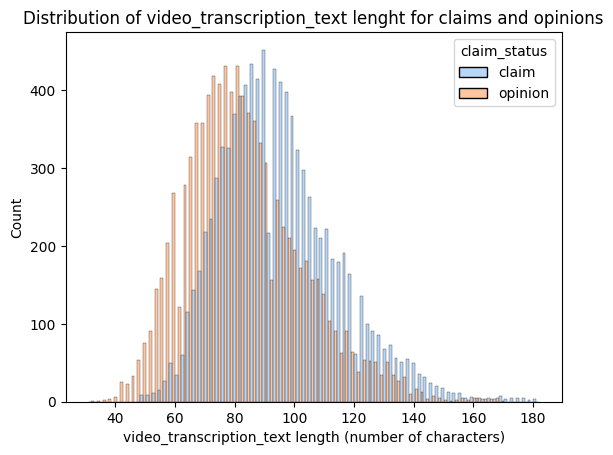

In [15]:
# Visualize the distribution of `video_transcription_text` length for claims and opinions
sns.histplot(data=data, stat='count', multiple='dodge', x='text_length',
             kde=False, palette='pastel', hue='claim_status',
             element='bars', legend=True)

plt.xlabel('video_transcription_text length (number of characters)')
plt.ylabel('Count')
plt.title('Distribution of video_transcription_text lenght for claims and opinions')
plt.show()


Letter count distributions for both claims and opinions are approximately normal with a slight right skew. Claim videos tent to have more characters--about 13 more on average, as indicate in a previous cell

One of the model assumptions for logistic regression is no severe multicollinearity among the features. Take this into consideration as you examine the heatmap and choose which features to proceed with.

**Feature selection and transformation**

Encode target and catgorical variables.

In [18]:
X = data.copy()
# Drop unnecessary columns
X = X.drop(['#', 'video_id'], axis=1)
# Enconde target variable
X['claim_status'] = X['claim_status'].replace({'opinion':0, 'claim': 1})
# Dummy encode remaining categorical values
X = pd.get_dummies(X,
                   columns=['verified_status','author_ban_status'],
                   drop_first=True)
X.head()


,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


### **Task 4. Split the data**


Assign target variable.

In this case, the target variable is `claim_status`.
* 0 represents an opinion
* 1 represents a claim

In [19]:
# Isolate target variable
y = X['claim_status']

Isolate the features.

In [20]:
# Isolate features
X = X.drop(['claim_status'], axis=1)

# Display first few rows of features dataframe
X.head()


,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


#### **Task 5: Create train/validate/test sets**

Split data into training and testing sets, 80/20.

In [36]:
# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Split the training set into training and validation sets, 75/25, to result in a final ratio of 60/20/20 for train/validate/test sets.

In [37]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

Confirm that the dimensions of the training, validation, and testing sets are in alignment.

In [38]:
# Get shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape


((11450, 11), (3817, 11), (3817, 11), (11450,), (3817,), (3817,))

### **BONUS CONTENT - Tokenize text column**

**NOTE:** You are not expected to do this or know this, but you might find it useful and/or interesting to understand some basic ideas behind natural language processing (NLP), because of the nature of the data provided in this TikTok project.

The feature `video_transcription_text` is text-based. It is not a categorical variable, since it does not have a fixed number of possible values. One way to extract numerical features from it is through a bag-of-words algorithm like [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

`CountVectorizer` works by splitting text into n-grams, which are groups of n consecutive words. For instance, "a dime for a cup of coffee" (phrase A) broken into 2-grams would result in six two-word combinations:

`a dime` | `dime for` |`for a`| `a cup` | `cup of` | `of coffee` |

Then, the next sample's text would be parsed into 2-grams. So, "ask for a cup for a child" (phrase B) would result in:

`ask for` |`for a`| `a cup` | `cup for` | `for a` | `a child` |

This process would repeat for each observation in the dataset, and each n-gram would be treated like a distinct feature. Then, the text of each observation is compared to the full array of n-grams, and the numbers of occurrences are tallied:

|  | `a dime` |`dime for`  |`for a`| `a cup` | `cup of` | `of coffee` | `ask for` | `cup for` | `a child` |
|--: |:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|phrase A |1|1|1|1|1|1|0|0|0|
|phrase B |0|0|2|1|1|0|1|1|1|
|**TOTAL**|1|1|3|2|2|1|1|1|1|

This would happen for the text of each observation in the data, and the text of each observation is parsed to get tallies for all the 2-word phrases from the entire data set for each observation, creating a large matrix.

If text is broken into 1-grams, then each feature in the matrix is an individual word.

After the count matrix has been created, `CountVectorizer` lets you the choose to keep only the most frequently occurring n-grams. You specify how many. The n-grams that you select can then be used as features in a model.

Splitting text into n-grams is an example of tokenization. Tokenization is the process of breaking text into smaller units to derive meaning from the resulting tokens.

This notebook breaks each video's transcription text into both 2-grams and 3-grams, then takes the 15 most frequently occurring tokens from the entire dataset to use as features.

In [41]:
# Set up a `CountVectorizer` object, which converts a collection of text to a matrix of token counts
count_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english')
count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

Fit the vectorizer to the training data (generate the n-grams) and transform it (tally the occurrences). Only fit to the training data, not the validation or test data.

In [42]:
# Extract numerical features from `video_transcription_text` in the training set
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()
count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [43]:
# Place the numerical representation of `video_transcription_text` from training set into a dataframe
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())

# Display first few rows
count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [44]:
# Concatenate `X_train` and `count_df` to form the final dataframe for training data (`X_train_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_train after dropping `video_transcription_text`,
# so that the indices align with those in `X_train` and `count_df`
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)

# Display first few rows
X_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,51,2487.0,310.0,20.0,1.0,0.0,134,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,43,118512.0,3543.0,374.0,70.0,29.0,97,False,True,False,...,0,1,0,0,0,0,0,0,0,0
2,22,105902.0,1885.0,229.0,39.0,9.0,76,False,False,True,...,0,1,0,0,0,0,0,0,0,0
3,17,9245.0,1670.0,440.0,13.0,4.0,58,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,18,3791.0,660.0,63.0,9.0,1.0,57,False,False,False,...,0,0,0,0,0,0,0,0,0,0


Get n-gram counts for the validation data. Notice that the vectorizer is not being refit to the validation data. It's only transforming it. In other words, the transcriptions of the videos in the validation data are only being checked against the n-grams found in the training data.

In [45]:
# Extract numerical features from `video_transcription_text` in the testing set
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_data

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [46]:
# Place the numerical representation of `video_transcription_text` from validation set into a dataframe
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
validation_count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [47]:
# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_val after dropping `video_transcription_text`,
# so that the indices align with those in `validation_count_df`
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), validation_count_df], axis=1)

# Display first few rows
X_val_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,11,578891.0,379596.0,14612.0,6591.0,44.0,72,False,False,True,...,0,0,0,0,0,0,0,1,0,0
1,24,6255.0,1709.0,311.0,13.0,1.0,96,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,35,410356.0,249714.0,26235.0,2060.0,1252.0,88,False,False,False,...,0,1,0,0,0,0,0,1,0,0
3,58,406911.0,25986.0,1230.0,564.0,248.0,83,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,47,972573.0,138167.0,25320.0,3331.0,968.0,104,False,False,True,...,0,0,0,0,0,0,0,1,0,0


Repeat the process to get n-gram counts for the test data. Again, don't refit the vectorizer to the test data. Just transform it.

In [48]:
# Extract numerical features from `video_transcription_text` in the testing set
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()

# Place the numerical representation of `video_transcription_text` from test set into a dataframe
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())

# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']
                                      ).reset_index(drop=True), test_count_df], axis=1)
X_test_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,54,692084.0,135956.0,16591.0,622.0,312.0,107,False,False,False,...,0,0,0,1,1,0,0,0,0,0
1,37,5164.0,1858.0,36.0,17.0,1.0,69,True,False,True,...,0,0,0,0,0,0,0,0,0,0
2,39,801951.0,344163.0,57608.0,8578.0,2942.0,90,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,44,6429.0,2314.0,847.0,17.0,5.0,76,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,26,555780.0,106863.0,15348.0,252.0,91.0,72,False,False,False,...,0,0,0,0,0,0,0,0,0,0


##### Pickle files

In [53]:
import pickle 

# Define a path to the folder where you want to save the model
path = 'models/'

In [54]:
def write_pickle(path, model_object, save_name:str):
    '''
    save_name is a string.
    '''
    with open(path + save_name + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [55]:
def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

### **Task 6. Build models**


### **Build a random forest model**

Fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall.

In [51]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

# Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')


In [61]:
rf = read_pickle(path,'randomForestModel')

In [52]:
%%time
##rf_cv.fit(X_train_final, y_train)


CPU times: total: 4min 43s
Wall time: 8min 2s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [60]:
write_pickle(path,rf,'randomForestModel')

CPU times: user 5min 37s, sys: 584 ms, total: 5min 37s
Wall time: 5min 37s

In [62]:
# Examine best recall score
rf_cv.best_score_


0.9948228253467271

In [63]:
# Examine best parameters
rf_cv.best_params_


{'max_depth': None,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

**Question:** How well is your model performing? Consider average recall score and precision score.

This model performs exceptionally well, with an average recall score of 0.995 across the five cross-validation folds. After checking the precision score to be sure the model is not classifying all samples as claims, it is clear that this model is making almost perfect classifications.

### **Build an XGBoost model**

In [65]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')


In [ ]:
xgb_cv = read_pickle(path,'xgboost')

In [66]:
%%time
xgb_cv.fit(X_train_final, y_train)

c:\Users\david\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\david\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\david\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\david\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

CPU times: total: 5min 7s
Wall time: 54.5 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

CPU times: total: 5min 7s
Wall time: 54.5 s

In [67]:
write_pickle(path,xgb_cv,'xgboost')

In [68]:
xgb_cv.best_score_

0.9898176171763818

In [69]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 300}

**Question:** How well does your model perform? Consider recall score and precision score.

This model also performs exceptionally well. Although its recall score is very slightly lower than the random forest model's, its precision score is perfect.

<img src="images/Execute.png" width="100" height="100" align=left>

## **PACE: Execute**
Consider the questions in your PACE Strategy Document to reflect on the Execute stage.

### **Task 7. Evaluate model**

Evaluate models against validation criteria.

#### **Random forest**

In [71]:
# Use the random forest "best estimator" model to get predictions on the validation set
y_pred = rf_cv.best_estimator_.predict(X_val_final)

Display the predictions on the encoded testing set.

In [72]:
# Display the predictions on the validation set
y_pred

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

Display the true labels of the testing set.

In [73]:
# Display the true labels of the validation set
y_val

5846     1
12058    0
2975     1
8432     1
6863     1
        ..
6036     1
6544     1
2781     1
6426     1
4450     1
Name: claim_status, Length: 3817, dtype: int64

Create a confusion matrix to visualize the results of the classification model.

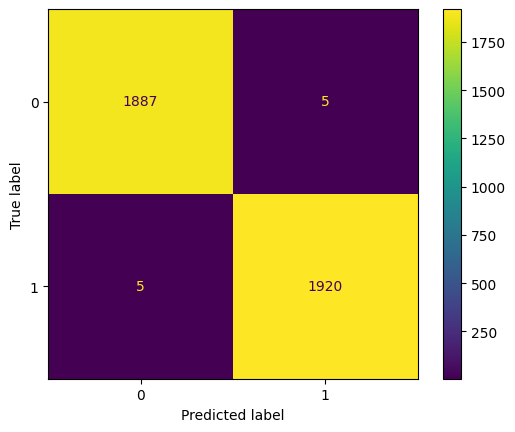

In [74]:
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

**Notes:**

The upper-left quadrant displays the number of true negatives: the number of opinions that the model accurately classified as so.

The upper-right quadrant displays the number of false positives: the number of opinions that the model misclassified as claims.

The lower-left quadrant displays the number of false negatives: the number of claims that the model misclassified as opinions.

The lower-right quadrant displays the number of true positives: the number of claims that the model accurately classified as so.

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

As the above confusion matrix shows, this model does not produce any false negatives.

Create a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the model.

In [75]:
# Create a classification report
# Create classification report for random forest model
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))


              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1892
       claim       1.00      1.00      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



**Question:** What does your classification report show? What does the confusion matrix indicate?

The classification report above shows that the random forest model scores were nearly perfect. The confusion matrix indicates that there were 10 misclassifications&mdash;five false postives and five false negatives.

#### **XGBoost**

Now, evaluate the XGBoost model on the validation set.

In [76]:
#Evaluate XGBoost model
y_pred = xgb_cv.best_estimator_.predict(X_val_final)

c:\Users\david\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\david\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\david\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\david\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

In [77]:
y_pred


array([1, 0, 1, ..., 1, 1, 1])

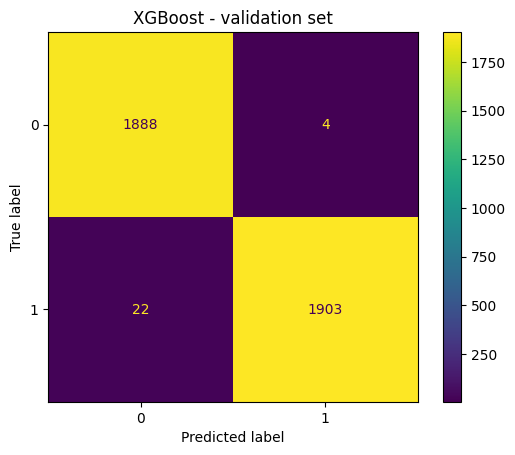

In [78]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('XGBoost - validation set');
plt.show()


In [79]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



**Question:** Describe your XGBoost model results. How does your XGBoost model compare to your random forest model?

The results of the XGBoost model were also nearly perfect. However, its errors tended to be false negatives. Identifying claims was the priority, so it's important that the model be good at capturing all actual claim videos. The random forest model has a better recall score, and is therefore the champion model.

### **Use champion model to predict on test data**

Both random forest and XGBoost model architectures resulted in nearly perfect models. Nonetheless, in this case random forest performed a little bit better, so it is the champion model.

Now, use the champion model to predict on the test data.

In [80]:
# Use champion model to predict on test data
y_pred = rf_cv.best_estimator_.predict(X_test_final)

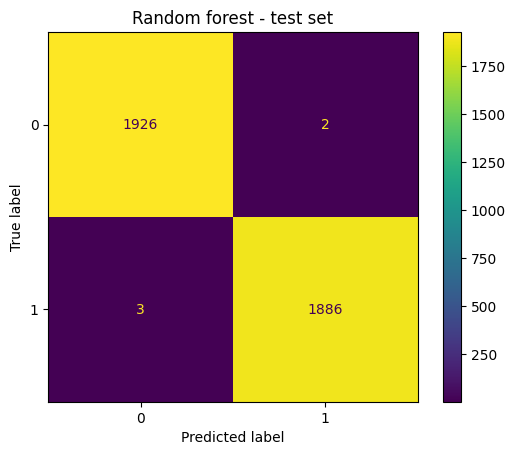

In [81]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('Random forest - test set');
plt.show()


#### **Feature importances of champion model**


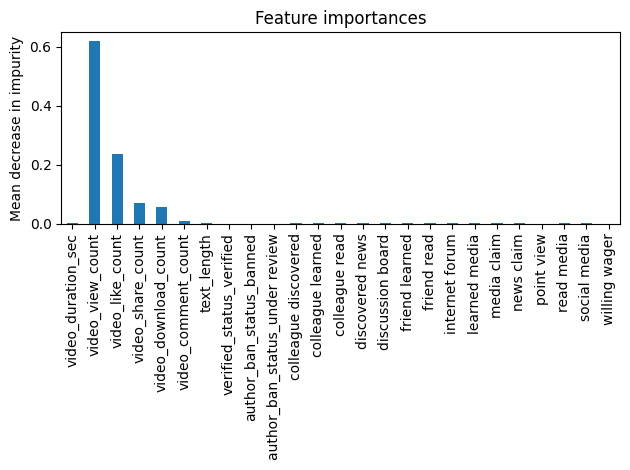

In [82]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test_final.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

**Question:** Describe your most predictive features. Were your results surprising?

The most predictive features all were related to engagement levels generated by the video. This is not unexpected, as analysis from prior EDA pointed to this conclusion.

### **Task 8. Conclusion**

In this step use the results of the models above to formulate a conclusion. Consider the following questions:

1. **Would you recommend using this model? Why or why not?**

2. **What was your model doing? Can you explain how it was making predictions?**

3. **Are there new features that you can engineer that might improve model performance?**

4. **What features would you want to have that would likely improve the performance of your model?**

Remember, sometimes your data simply will not be predictive of your chosen target. This is common. Machine learning is a powerful tool, but it is not magic. If your data does not contain predictive signal, even the most complex algorithm will not be able to deliver consistent and accurate predictions. Do not be afraid to draw this conclusion.


**Response:**

1. *Would you recommend using this model? Why or why not?*
Yes, one can recommend this model because it performed well on both the validation and test holdout data. Furthermore, both precision and F<sub>1</sub> scores were consistently high. The model very successfully classified claims and opinions.
</br>
2. *What was your model doing? Can you explain how it was making predictions?*
The model's most predictive features were all related to the user engagement levels associated with each video. It was classifying videos based on how many views, likes, shares, and downloads they received.
</br>
3. *Are there new features that you can engineer that might improve model performance?*
Because the model currently performs nearly perfectly, there is no need to engineer any new features.
</br>
4. *What features would you want to have that would likely improve the performance of your model?*
The current version of the model does not need any new features. However, it would be helpful to have the number of times the video was reported. It would also be useful to have the total number of user reports for all videos posted by each author.